In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


## 1. Introduction

**Objective:**

To categorise the countries using socio-economic and health factors that determine the overall development of the country.

**About organization:**

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities.

**Problem Statement:**

HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

## 2. Import Libraries, Load/Clean Data

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
df.shape

(167, 10)

In [6]:
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [7]:
df.duplicated().sum()

0

#### **Key Observations:**

1. 167 rows, 10 columns – A manageable dataset for clustering.
2. Data types are appropriate:
- The country column is object, which means it’s categorical and won’t be used for clustering directly.
- The rest of the columns are numerical, which is ideal for clustering algorithms.
3. No missing or duplicate values, meaning no preprocessing needed for data cleaning—we can move directly to EDA and feature scaling.

## 3. EDA

This is a critical step in the data science workflow, as it helps us understand the dataset’s structure, relationships, and patterns before applying machine learning models. In this project, EDA will allow us to gain insights into socio-economic and health factors that influence a country’s development and aid allocation through these four ways:
1. Understand Feature Distributions: Visualizing numerical variables (e.g., histograms, boxplots) helps us understand their spread, skewness, and presence of outliers.

2. Identify Relationships Between Variables: Using correlation heatmaps and scatter plots, we can determine how features relate to each other, which aids in feature selection and interpretation.
3. Detect Outliers and Anomalies: Outliers can affect clustering performance. Identifying them early allows us to decide whether to keep or remove them.
4. Ensure Data Suitability for Clustering: Checking for patterns, variance, and scale differences ensures the dataset is properly prepared for unsupervised learning techniques.

Let's begin with univariate analysis by plotting histograms and boxplots for all numerical features to understand their distributions and detect potential outliers.

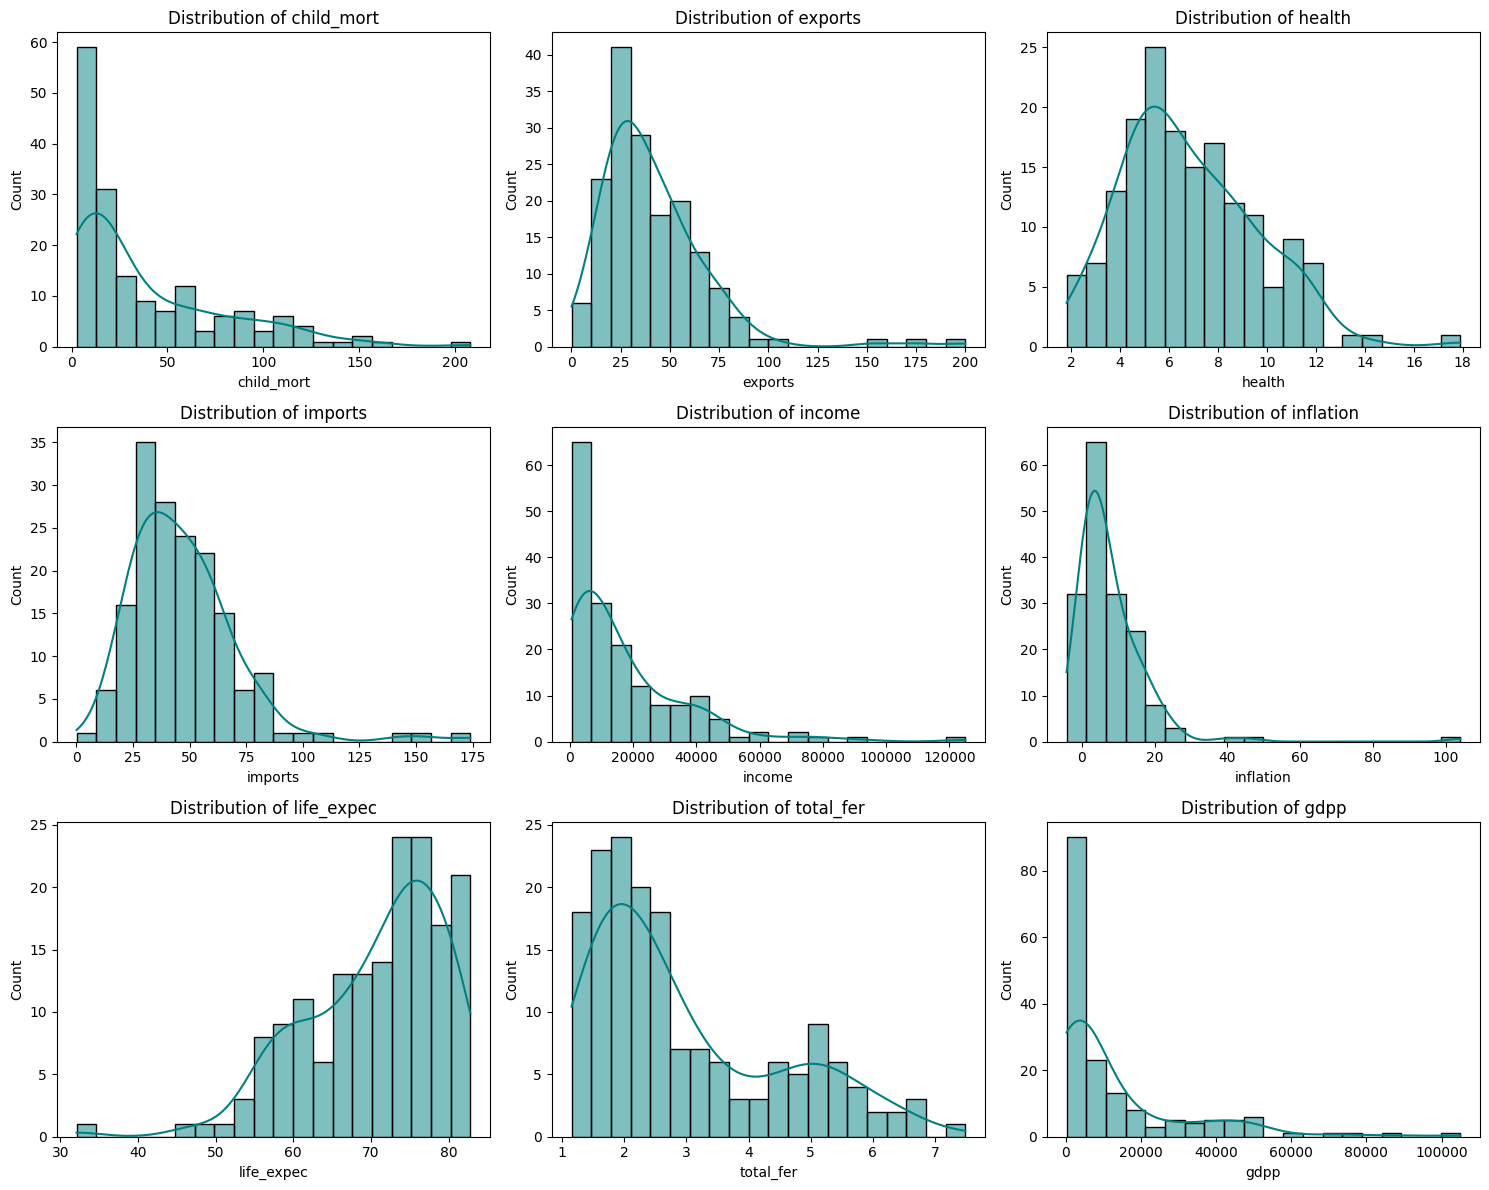

In [10]:
# Define numerical columns
num_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 
            'inflation', 'life_expec', 'total_fer', 'gdpp']

# Set up figure size
plt.figure(figsize=(15, 12))

# Plot histograms
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], bins=20, kde=True, color='teal')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

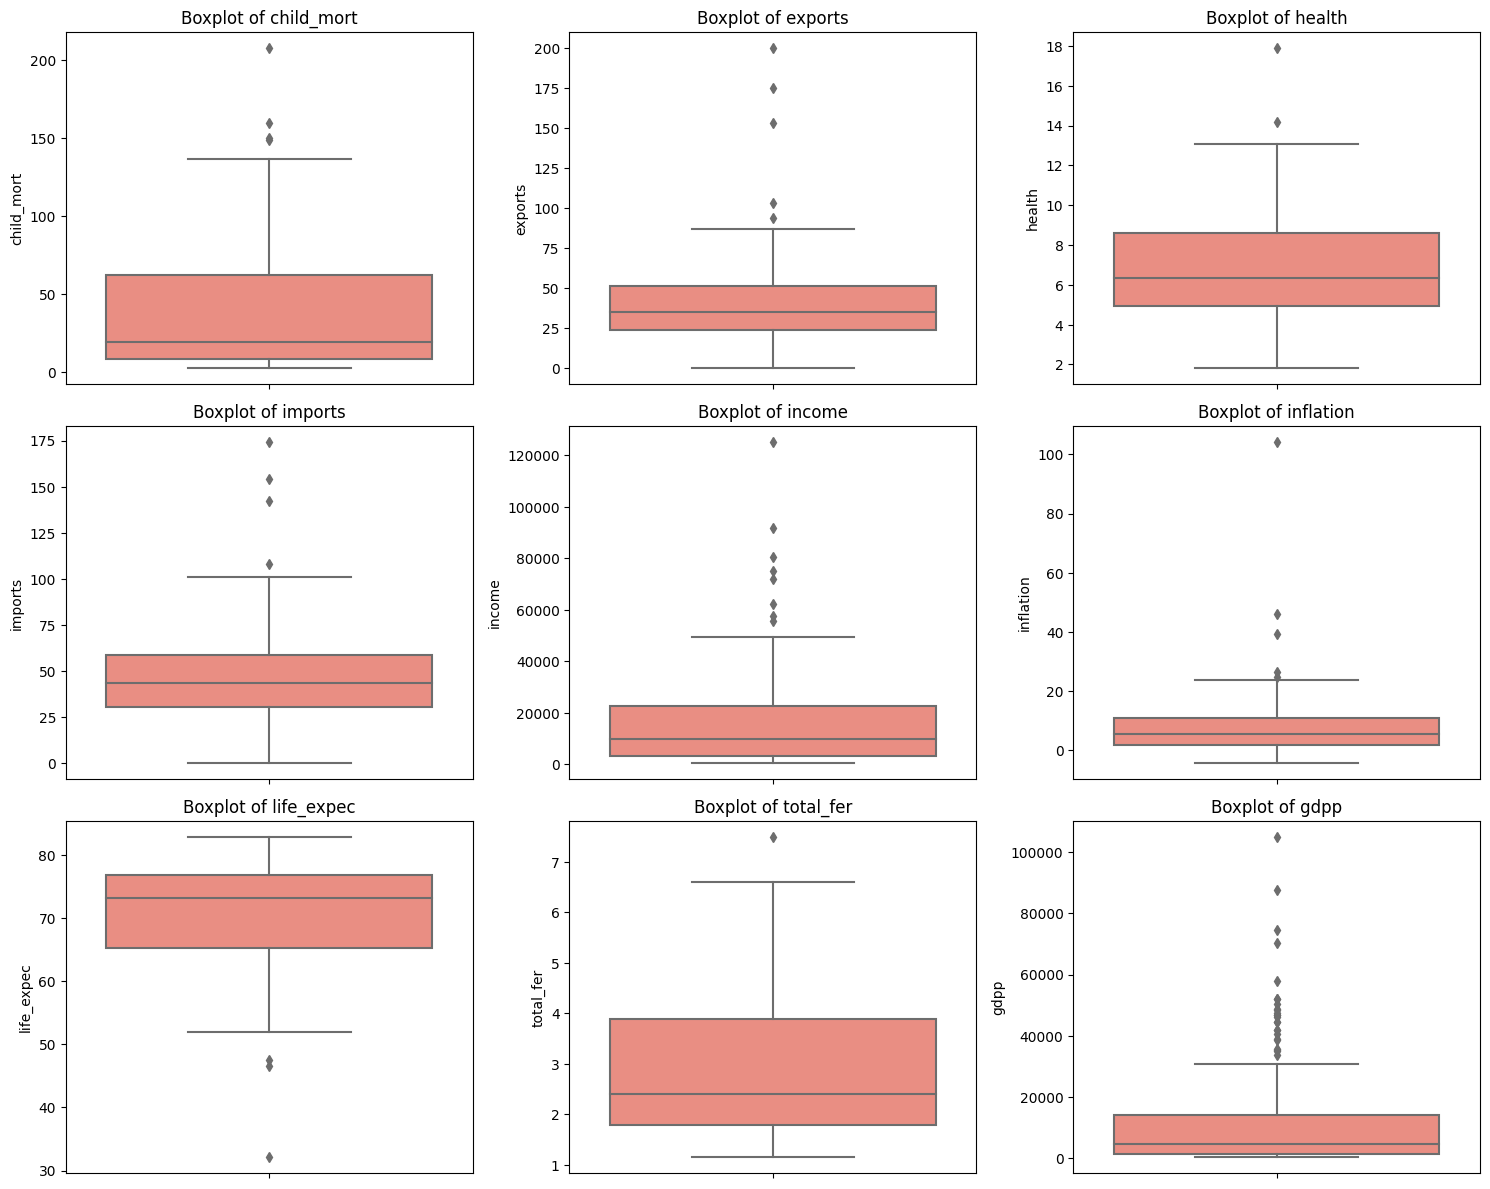

In [11]:
# Boxplots to check for outliers
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

#### Some Notes on the plots:

- Several variables, including child_mort, exports, imports, income, inflation, total_fer, and gdpp, exhibit strong right skewness.
- This suggests that most countries have lower values for these metrics, with a few having significantly high values (outliers).
- We may need log transformations or scaling techniques to normalize these features before applying clustering algorithms.
- Life expectancy (life_expec) is left-skewed, indicating that most countries have a relatively high life expectancy, but a few have significantly lower values.
- Health expenditure (health) is roughly normally distributed but has a slight right skew, meaning a majority of countries spend a moderate amount on healthcare.
- Outliers are present in almost all variables, with gdpp having the most extreme values.
- Total fertility rate (total_fer) has only one outlier.
- The presence of outliers suggests that we should consider using robust scaling methods or clustering techniques that are less sensitive to extreme values, such as DBSCAN or Hierarchical Clustering instead of K-Means.

Since GDP per capita (gdpp), income, child mortality (child_mort), and life expectancy (life_expec) are key indicators of development, let’s plot some targeted scatter plots:

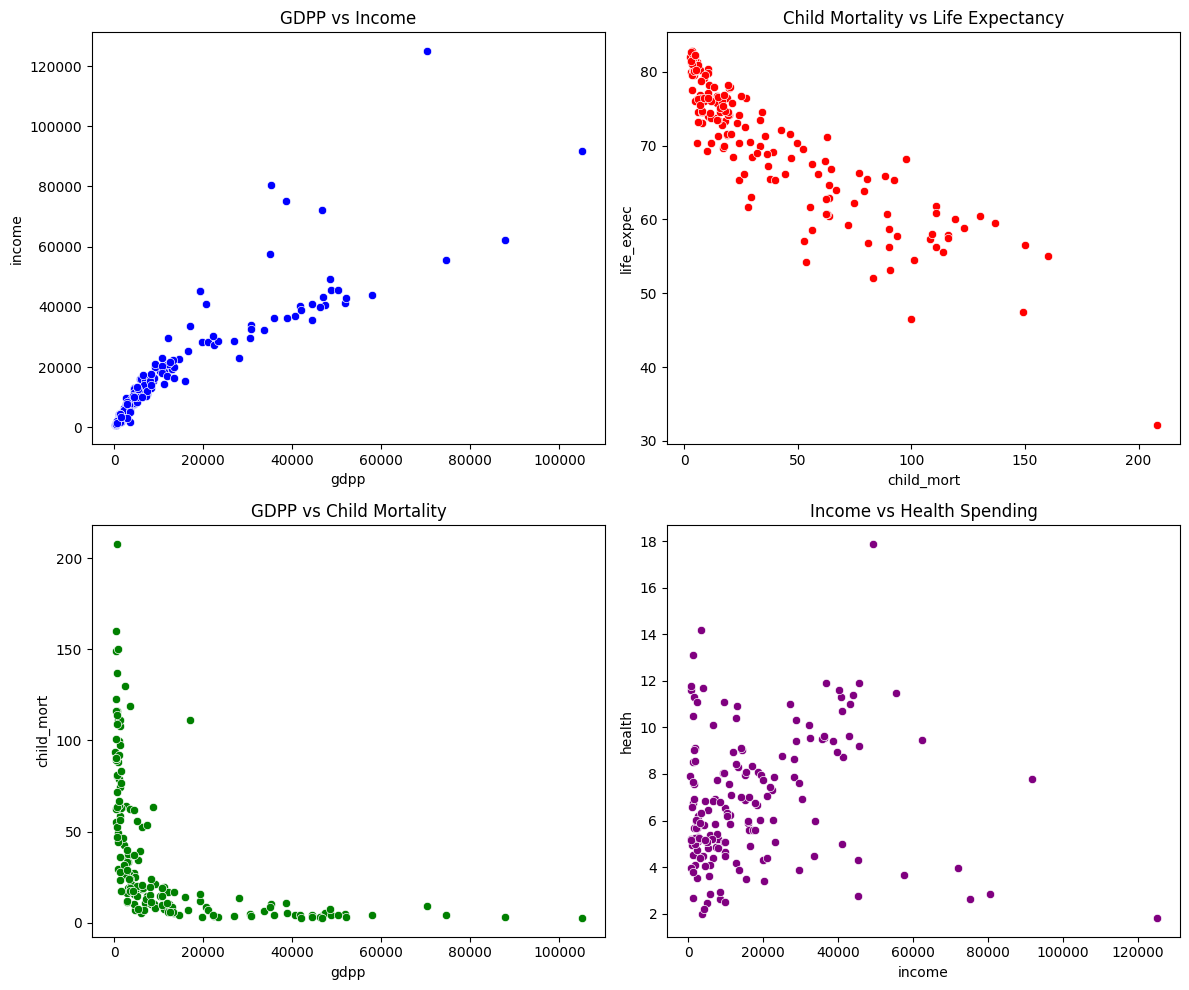

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# GDPP vs Income
sns.scatterplot(data=df, x="gdpp", y="income", ax=axes[0, 0], color="blue")
axes[0, 0].set_title("GDPP vs Income")

# Child Mortality vs Life Expectancy
sns.scatterplot(data=df, x="child_mort", y="life_expec", ax=axes[0, 1], color="red")
axes[0, 1].set_title("Child Mortality vs Life Expectancy")

# GDPP vs Child Mortality
sns.scatterplot(data=df, x="gdpp", y="child_mort", ax=axes[1, 0], color="green")
axes[1, 0].set_title("GDPP vs Child Mortality")

# Income vs Health Spending
sns.scatterplot(data=df, x="income", y="health", ax=axes[1, 1], color="purple")
axes[1, 1].set_title("Income vs Health Spending")

plt.tight_layout()
plt.show()

#### **What These Scatter Plots Reveal:**
- Countries with higher GDP per capita (gdpp) tend to have higher income levels.
- Higher child mortality rates are usually associated with lower life expectancy.
- Lower GDP per capita (gdpp) is often linked with higher child mortality (child_mort).
- Higher health spending does not always correlate directly with higher income.

Let's compare the countries according to GDP category

In [18]:
df1 = df.copy()
# Define GDP categories based on percentiles
df1["GDP_Category"] = pd.qcut(df1["gdpp"], q=3, labels=["Low", "Medium", "High"])

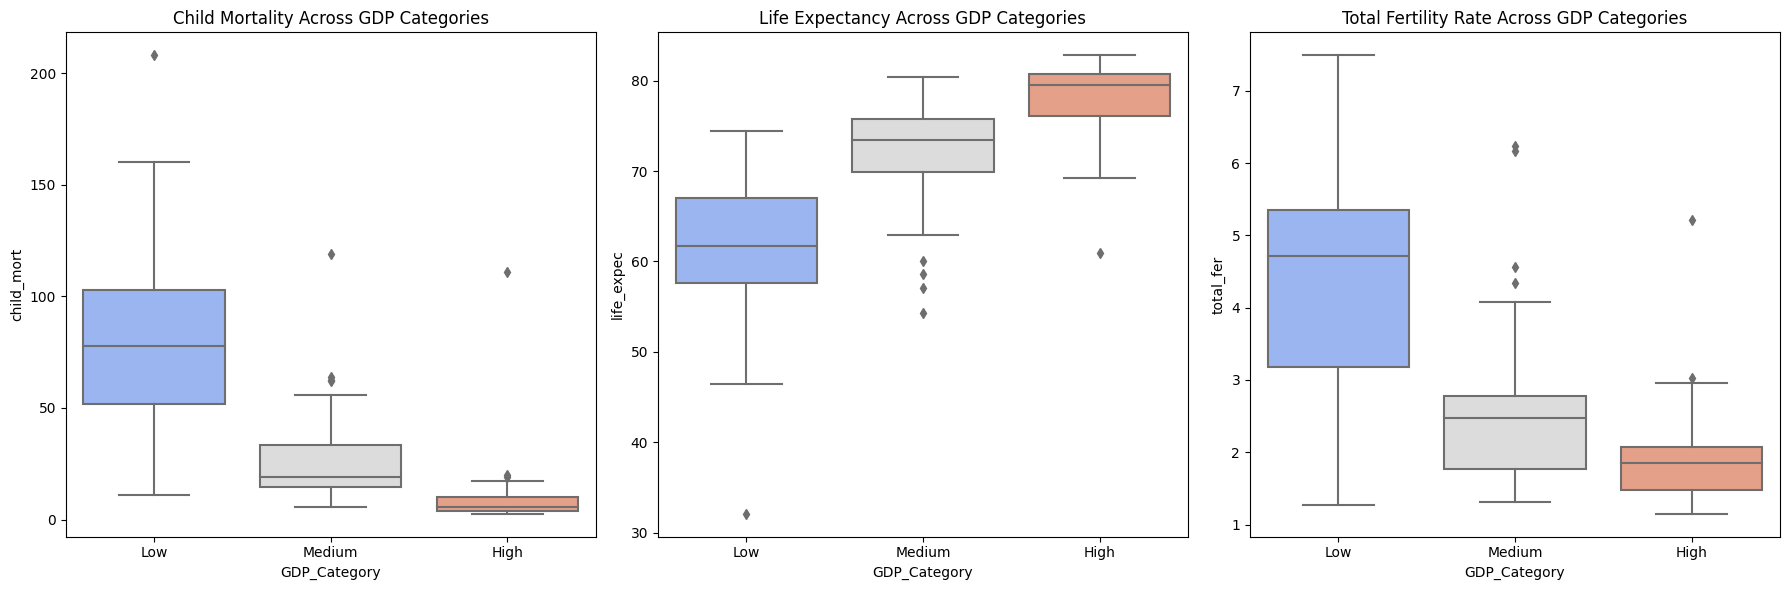

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Child Mortality vs GDP Category
sns.boxplot(data=df1, x="GDP_Category", y="child_mort", ax=axes[0], palette="coolwarm")
axes[0].set_title("Child Mortality Across GDP Categories")

# Life Expectancy vs GDP Category
sns.boxplot(data=df1, x="GDP_Category", y="life_expec", ax=axes[1], palette="coolwarm")
axes[1].set_title("Life Expectancy Across GDP Categories")

# Total Fertility Rate vs GDP Category
sns.boxplot(data=df1, x="GDP_Category", y="total_fer", ax=axes[2], palette="coolwarm")
axes[2].set_title("Total Fertility Rate Across GDP Categories")

plt.tight_layout()
plt.show()

## 4. Clustering

**Steps for Clustering:**
1. Feature Scaling – We’ll standardize the numerical variables using StandardScaler or MinMaxScaler.
2. Finding Optimal Clusters – We’ll use Elbow Method and Silhouette Score to determine the ideal number of clusters.
3. Perform Dimensionality Reduction– We’ll apply Principal Component Analysis (PCA) to see if it improves our model.
4. Compare Results Before and After – We’ll then compare the results to see if performing dimensionality reduction on our dataset improved the model.

#### **Scaling**

Since K-Means and Hierarchical Clustering are distance-based algorithms, feature scaling is crucial to ensure that all variables contribute equally. There are two options for this, StandardScaler and MinMaxScaler. Given that our dataset has skewed distributions, MinMaxScaler may be the better choice, as it maintains the original distribution while bringing all values to the same scale.

In [22]:
# Selecting only the numerical columns (excluding 'country')
num_cols = df.columns[1:]

# Initializing the scaler
scaler = MinMaxScaler()

# Applying the scaler to numerical columns
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

# Display the first few rows of the scaled dataset
df_scaled.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,Albania,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,Algeria,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,Angola,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,Antigua and Barbuda,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


**Finding Optimal Clusters**

Now, let's determine the optimal number of clusters using the Elbow Method and the Silhouette Score.

In [23]:
# Define the range of clusters to test
k_values = range(2, 11)

# Lists to store metrics
inertia_values = []
silhouette_scores = []

# Iterate over different cluster sizes
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled.iloc[:, 1:])  # Excluding the 'country' column
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled.iloc[:, 1:], kmeans.labels_))

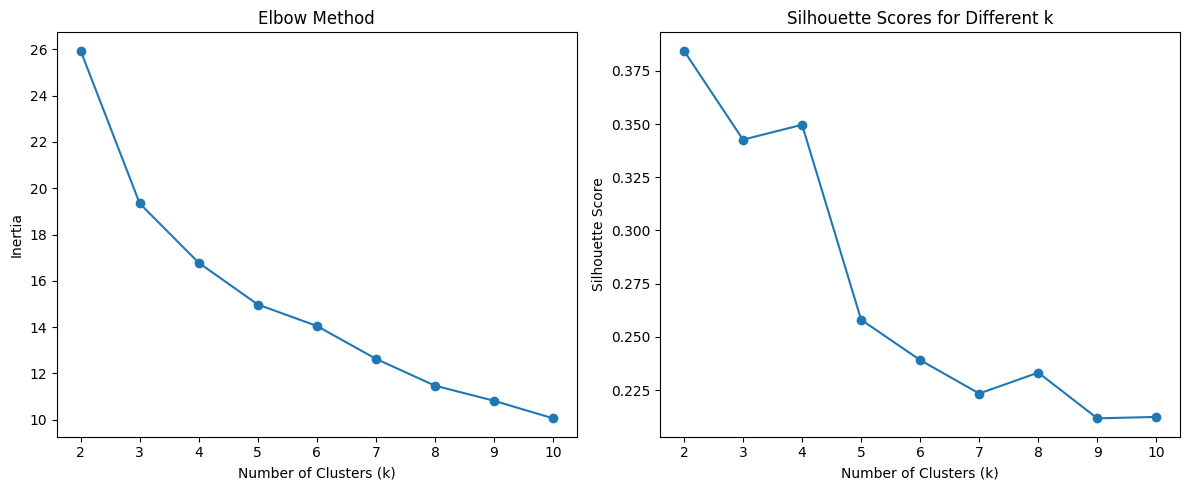

In [25]:
# Plot the Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")

plt.tight_layout()
plt.show()

#### **Dimensionality Reduction**

We can see from the plots above that our optimall k=3. Now, let's apply dimensionality reduction to see if it changes this.

Total variance explained by 2 components: 0.68


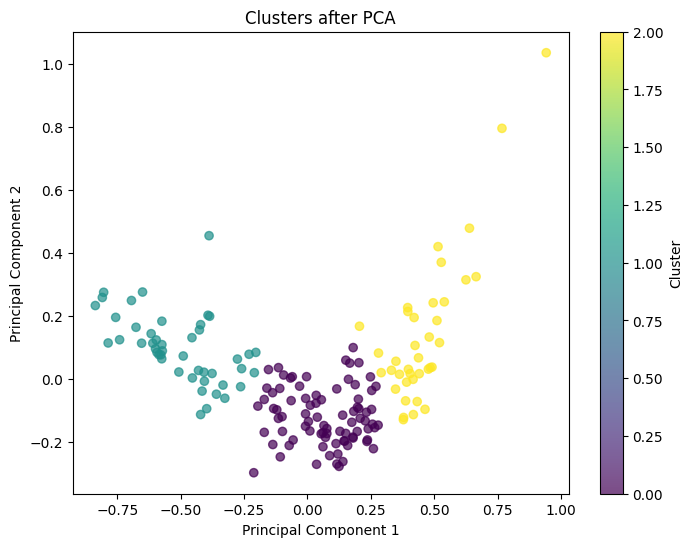

In [27]:
optimal_k = 3

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Reduce to 2D for easy visualization
df_pca = pca.fit_transform(df_scaled.iloc[:, 1:])  # Exclude 'country'

# Explained variance ratio
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total variance explained by 2 components: {explained_variance:.2f}")

# Convert to DataFrame for clustering
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Perform clustering on reduced dimensions
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans_pca.fit_predict(df_pca)

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clusters after PCA")
plt.colorbar(label="Cluster")
plt.show()

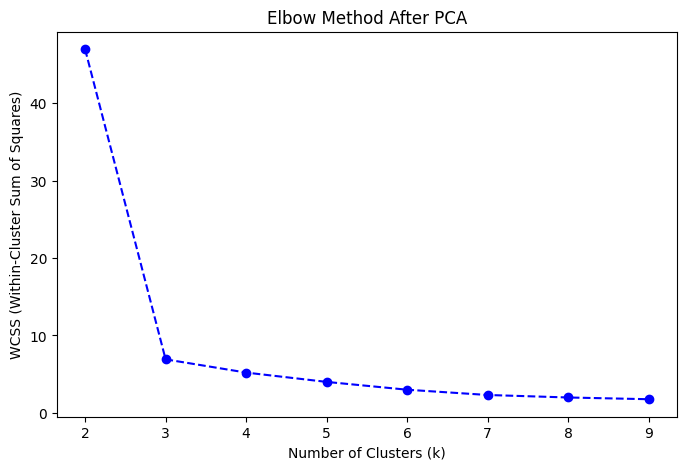

In [28]:
wcss_pca = []
K_range = range(2, 10)  # Testing for k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    wcss_pca.append(kmeans.inertia_)

# Plot elbow method
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss_pca, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method After PCA')
plt.show()

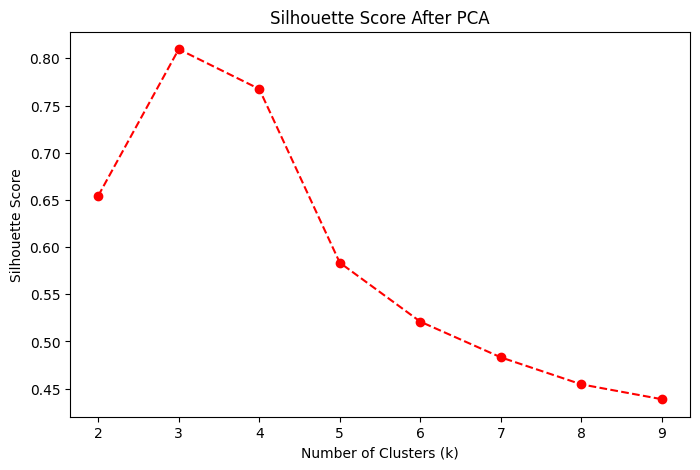

In [29]:
silhouette_scores_pca = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_pca)
    silhouette_scores_pca[k] = silhouette_score(df_pca, labels)

# Plot Silhouette Score
plt.figure(figsize=(8,5))
plt.plot(silhouette_scores_pca.keys(), silhouette_scores_pca.values(), marker='o', linestyle='--', color='r')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score After PCA')
plt.show()

## 5. Conclusion

In this project, we performed unsupervised learning to categorize countries based on socio-economic and health indicators, helping HELP International strategically allocate aid to the nations in greatest need.

✅ **Data Exploration & Preprocessing**

- The dataset contained 167 countries with no missing or duplicate values.
- Most features were right-skewed, requiring standardization before clustering.
- Outliers were present in all numerical variables, especially GDP per capita (gdpp).

✅ **Clustering Analysis**

- We used the Elbow Method and Silhouette Scores to determine the optimal number of clusters.
- Both before and after PCA, the best choice for k was 3, meaning countries naturally grouped into three distinct categories.
- K-Means clustering successfully grouped countries based on child mortality, GDP per capita, health expenditure, and other socio-economic factors.

✅ **Dimensionality Reduction (PCA)**

- PCA reduced the dataset while preserving 68% of the variance in just two principal components.
- The clusters remained well-separated after PCA, confirming that three clusters were the best fit.

**Final Recommendations**

Countries in the poorest cluster (high child mortality, low income, low GDP) should be prioritized for aid.
Middle-income countries may benefit from development projects rather than direct financial aid.
High-GDP countries require minimal intervention.